## 1. 데이터 로드!

In [23]:
import os
import json
import h5py

import pandas as pd
import numpy as np

### 우리가 분류해야되는 Class를 확인해보자
 ❕ 원래 대/중/소/세분류로 나누어져 있지만, 대분류만 Classify할 예정이다!

In [2]:
cate = json.loads(open('./data/cate1.json', 'rb').read().decode('utf-8'))
count_big = len(cate['b']);
print(f'대분류 갯수 : {count_big}')

대분류 갯수 : 57


In [3]:
str(cate['b'])[:500] # 대분류 조금만 살펴보기!

"{'가공식품/과자/초콜릿': 27, '수납/정리/선반': 21, '디카/캠코더/주변기기': 32, '침구/커튼/카페트': 8, '데스크탑/모니터/PC부품': 39, '상품권/e쿠폰/서비스': 54, '해외여행': 56, '내비/블랙박스/하이패스': 52, '홈/인테리어/가드닝': 11, '주방가전/냉장고/전기밥솥': 42, '영상가전/TV/홈시어터': 38, '도서/음반/DVD': 53, '쥬얼리/시계/액세서리': 20, '노트북/태블릿PC': 49, '향수/바디/헤어': 37, '문구/사무/용지': 35, '게임/주변기기': 29, '거실/주방가구': 36, '홈오피스/키즈가구': 45, '국내여행': 55, '자동차용품': 34, '자전거/인라인/모터사이클': 44, '반려동물/애완용품': 50, '욕실/청소/세제': 40, '유아동의류/신발/가방': 22, '이미용/건강/욕실가전': 26, '쌀/과일/농축수산물': 51, '음향가전/스피커/전자사전': 25, '건강관리/실버용품"

In [34]:
cate_dict = {v:k for k,v in cate['b'].items()} # key-value바꾼 딕셔너리 만들기!
cate_dict[27]

'가공식품/과자/초콜릿'

### 우리가 traing해야되는 data를 살펴보자

In [5]:
data = h5py.File('./data/train.chunk.01', 'r')

In [6]:
train = data['train']

In [7]:
train.keys() # 상품의 feature

<KeysViewHDF5 ['bcateid', 'brand', 'dcateid', 'img_feat', 'maker', 'mcateid', 'model', 'pid', 'price', 'product', 'scateid', 'updttm']>

bcateid | brand | dcateid | img_feat | maker | mcateid | model | pid | price | product | scateid | updttm
-------- | ------ | -------- | -------- | ------ | -------- | ------ | ------ | ---- | ------ | --------- | -------------
대분류ID | 브랜드 | 세분류ID | 이미지특징 | 제조사 | 중분류ID | 상품ID | 상품ID | 가격 | 상품명 | 소분류ID | 업데이트 시간

In [8]:
# 첫 데이터만 살펴보자!
for i in train.keys():
    sample = train[i][0]
    if i in ['brand', 'product', 'maker', 'model']:
        sample = sample.decode('utf-8')
    print(f'{i}: {sample}');

bcateid: 1
brand: 퍼즐라이프
dcateid: -1
img_feat: [0.75723773 0.8849334  0.0776659  ... 0.         1.0283663  0.0683253 ]
maker: 상품상세설명 참조
mcateid: 1
model: 퍼즐라이프 직소퍼즐 바다거북의 여행
pid: b'O4486751463'
price: 16520
product: 직소퍼즐 - 1000조각 바다거북의 여행 (PL1275)
scateid: 2
updttm: b'20180227091029'


In [9]:
train["img_feat"]

<HDF5 dataset "img_feat": shape (1000000, 2048), type "<f4">

~~오픈소스 플젝은 이미지 Classification을 해서 재밌게 해야지 라고 생각했는데 이미지가 픽셀 정보가 아니라 이미 처리가 되어있었다.. 이걸 원본 이미지로 돌릴 순 없겠죠..?😂 ~~

In [10]:
count_data = len(train["bcateid"])
print(f'데이터 갯수 : {count_data}')

데이터 갯수 : 1000000


## 2. Train Data를 Train / Validation으로 분리!

카카오 아레나에서 Test set은 제공해주므로 Validation set만 만들 것이다!(But, 이번 플젝은 테스트까진 안하고 Validation까지만!)

In [56]:
from keras.utils.np_utils import to_categorical

on_hot_label = to_categorical(train["bcateid"]) # 대분류를 one-hot 인코딩!

In [57]:
on_hot_label

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [58]:
# train : vlidation : test = 640000 : 160000 : 200000

X_train = train["img_feat"][:6400]
X_val = train["img_feat"][6400:6400+1600]
X_test = train["img_feat"][6400+1600:]

y_train = on_hot_label[:6400]
y_val = on_hot_label[6400:6400+1600]
y_test = on_hot_label[6400+1600:]

In [59]:
 y_train[1:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 3. 모델 training

데이터 전처리를 해야되지만.. 앞에서 마주친 작지만 나를 힘들게한 오류들 때문에.. 시간이 부족하니 냅다 훈련부터 해본다..! 

❕ 모델은 img_feat만 가지고 훈련해볼 것이다!

☑️ Hyperparameter

| Hyperparameter | My Model | 
| :---------- | :---------------------------------------------- |
| # input neurons | 2048(img_feat의 colums) | 
| # hidden layers | 1 |
| # neurons per hidden layer | 100 |
| # output neurons | 57(대분류 갯수) |
| output layer activation | Softmax(1개의 class에만 할당될 수 있어서!) |
| Loss function | Cross entropy(Classification 문제라서!) |

*왜인지 모르겠지만 output neurons을 53으로 바꾸라고 오류가 나서 57 -> 53으로 바꾸었다!!*

In [75]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(2048, activation='relu'))# input layer
model.add(layers.Dense(100, activation='relu')) # hidden layer
model.add(layers.Dense(53, activation='softmax')) # output layer

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
200/200 [==============================] - 29s 128ms/step - loss: 1.3636 - accuracy: 0.6205 - val_loss: 1.6307 - val_accuracy: 0.5938
Epoch 2/20
200/200 [==============================] - 24s 122ms/step - loss: 1.0001 - accuracy: 0.7055 - val_loss: 1.8160 - val_accuracy: 0.5494
Epoch 3/20
200/200 [==============================] - 26s 131ms/step - loss: 0.7387 - accuracy: 0.7770 - val_loss: 1.7530 - val_accuracy: 0.6031
Epoch 4/20
200/200 [==============================] - 28s 138ms/step - loss: 0.5332 - accuracy: 0.8352 - val_loss: 1.8920 - val_accuracy: 0.5944
Epoch 5/20
200/200 [==============================] - 26s 129ms/step - loss: 0.3823 - accuracy: 0.8752 - val_loss: 2.0299 - val_accuracy: 0.5900
Epoch 6/20
200/200 [==============================] - 26s 131ms/step - loss: 0.2854 - accuracy: 0.9048 - val_loss: 2.1851 - val_accuracy: 0.6225
Epoch 7/20
200/200 [==============================] - 26s 129ms/step - loss: 0.2231 - accuracy: 0.9267 - val_loss: 2.5337 - val_ac

### 결과를 한 번 그려봅시다!

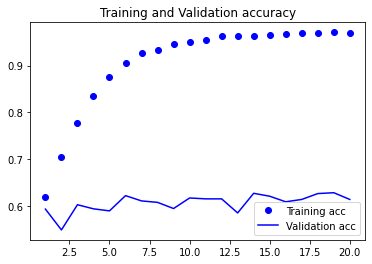

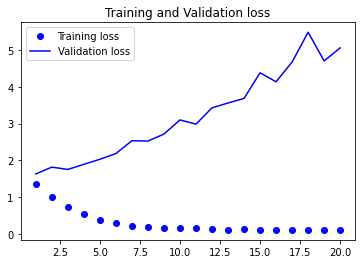

In [72]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

헿 오버피팅됐다..!! 😅

In [70]:
model.evaluate(X_test, y_test)

31000/31000 [==============================] - 287s 9ms/step - loss: 4.9703 - accuracy: 0.6281


[4.970290184020996, 0.6281300187110901]

## 최종 정확도: 62% 👏👏

아주 만족스럽진 않지만, 끝까지 마무리한 나 자신이 너무 대견하다🥺 아쉬운 결과가 아른거린다면 이 모델을 좀 더 개선시키러 돌아와야지..!